In [1]:
# ==== Core ====
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# ==== Viz ====
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from IPython.display import display

# ==== Stats / Transforms ====
from scipy.special import boxcox1p
from mplfinance.original_flavor import candlestick_ohlc

# ==== Scikit-learn ====
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, LabelEncoder,
    StandardScaler, MinMaxScaler, RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
import matplotlib
matplotlib.rc('font', family='NanumGothic')  # 또는 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

In [69]:
os.chdir(r'C:\Users\USER\Documents\dev\upstage-ml-regression-sigma7\data')

In [70]:
# load data
train_file = r'train.csv'
test_file = r'test.csv'
train = pd.read_csv(train_file, encoding= 'utf-8')
test = pd.read_csv(test_file, encoding= 'utf-8')
bus = pd.read_csv('bus_feature.csv', encoding= 'utf-8')
subway = pd.read_csv('subway_feature.csv', encoding= 'utf-8')
print('train 데이터입니다.')
train


train 데이터입니다.


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,124000
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,123500
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,91500
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,117000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000
1118819,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,28000
1118820,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,0.0,366.0,의무,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,29000


In [71]:
# train, test 데이터 합치기
train['train_data'] = 1
test['train_data'] = 0

train  = pd.concat([train, test]).reset_index(drop=True)

In [72]:
# 계약년월 -> 계약년, 계약월
train['계약년월'] = pd.to_datetime(train['계약년월'], format='%Y%m' )

train['계약년'] = train['계약년월'].dt.year
train['계약월'] = train['계약년월'].dt.month

train.drop('계약년월', axis=1, inplace=True)

In [73]:
# 전용면적(㎡) -> 전용면적
train = train.rename(columns={'전용면적(㎡)':'전용면적'})


In [74]:
# 결측치 확인
print('* 결측치가 100만개 이하인 변수들 :', list(train.columns[train.isnull().sum() <= 1000000]))     

print('* 결측치가 100만개 이상인 변수들 :', list(train.columns[train.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'train_data', '계약년', '계약월']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [75]:
# 결측치 확인
train.isnull().sum().sort_values(ascending=False)

k-135㎡초과                  1127765
해제사유발생일                   1121899
k-등록일자                    1116386
단지소개기존clob                1058958
k-홈페이지                    1013523
고용보험관리번호                   920757
세대전기계약방법                   885389
k-팩스번호                     879348
k-시행사                      877834
청소비관리형태                    877751
k-건설사(시공사)                 877637
경비비관리형태                    877561
k-단지분류(아파트,주상복합등등)         877273
k-전체동수                     877207
단지승인일                      876854
k-전화번호                     876850
k-복도유형                     876454
건축면적                       876279
주차대수                       876277
k-사용검사일-사용승인일              876259
좌표X                        876232
좌표Y                        876232
단지신청일                      876187
k-수정일자                     876170
k-85㎡~135㎡이하               876170
k-전용면적별세대현황(60㎡~85㎡이하)     876170
k-전용면적별세대현황(60㎡이하)         876170
k-주거전용면적                   876170
k-관리비부과면적                  876125
k-연면적         

In [76]:
# 전용면적 비
total = (
train['k-전용면적별세대현황(60㎡이하)'].fillna(0) +
train['k-전용면적별세대현황(60㎡~85㎡이하)'].fillna(0) +
train['k-85㎡~135㎡이하'].fillna(0) +
train['k-135㎡초과'].fillna(0)
)

train['소형비율'] = train['k-전용면적별세대현황(60㎡이하)'] / total
train['중소형비율'] = train['k-전용면적별세대현황(60㎡~85㎡이하)'] / total
train['중대형비율'] = train['k-85㎡~135㎡이하'] / total
train['대형비율'] = train['k-135㎡초과'] / total

In [77]:
# 불필요한 변수 제거
train.drop(['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지',
             'k-등록일자','k-85㎡~135㎡이하','k-전용면적별세대현황(60㎡~85㎡이하)',
             'k-전용면적별세대현황(60㎡이하)'], axis=1, inplace=True)

In [78]:
# 연속형, 범주형 변수 구분
continuous_columns = []
categorical_columns = []

for column in train.columns:
    if pd.api.types.is_numeric_dtype(train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['본번', '부번', '전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'train_data', '계약년', '계약월', '소형비율', '중소형비율', '중대형비율', '대형비율']
범주형 변수: ['시군구', '번지', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [79]:
# 복제
train_main = train.copy()

In [80]:
# 불필요한 변수 제거
train_main.drop(['대형비율', '고용보험관리번호', 'k-팩스번호', 'k-전화번호', 'k-수정일자','k-시행사','관리비 업로드','사용허가여부','중개사소재지','등기신청일자'],axis=1, inplace=True)

In [81]:
# 결측치 확인
train_main.isnull().sum().sort_values(ascending=False)

세대전기계약방법               885389
청소비관리형태                877751
k-건설사(시공사)             877637
중대형비율                  877611
중소형비율                  877611
소형비율                   877611
경비비관리형태                877561
k-단지분류(아파트,주상복합등등)     877273
k-전체동수                 877207
단지승인일                  876854
k-복도유형                 876454
건축면적                   876279
주차대수                   876277
k-사용검사일-사용승인일          876259
좌표X                    876232
좌표Y                    876232
단지신청일                  876187
k-주거전용면적               876170
기타/의무/임대/임의=1/2/3/4    876125
k-관리비부과면적              876125
k-연면적                  876125
k-난방방식                 876125
k-관리방식                 876125
k-세대타입(분양형태)           876125
k-전체세대수                876125
target                   9272
아파트명                     2136
번지                        227
본번                         75
부번                         75
계약월                         0
계약년                         0
train_data                  0
계약일       

In [82]:
# 결측치 0으로 채우기
train_main[['중대형비율','중소형비율','소형비율']].fillna(0, inplace=True)

In [83]:
# '시군구' value 확인
train_main['시군구'].value_counts()

서울특별시 노원구 상계동    45232
서울특별시 노원구 중계동    26524
서울특별시 양천구 신정동    23768
서울특별시 도봉구 창동     23222
서울특별시 구로구 구로동    22941
                 ...  
서울특별시 중구 필동1가        6
서울특별시 용산구 주성동        5
서울특별시 종로구 연지동        4
서울특별시 중구 입정동         3
서울특별시 마포구 구수동        3
Name: 시군구, Length: 339, dtype: int64

In [84]:
# '시군구' -> '구', '동' 분리
train_main['구'] = train_main['시군구'].apply(lambda x: str(x).split(' ')[1] if len(str(x).split(' ')) > 1 else '기타')
train_main['동'] = train_main['시군구'].apply(lambda x: str(x).split(' ')[2] if len(str(x).split(' ')) > 2 else '기타')
train_main.drop('시군구', axis=1, inplace=True)

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

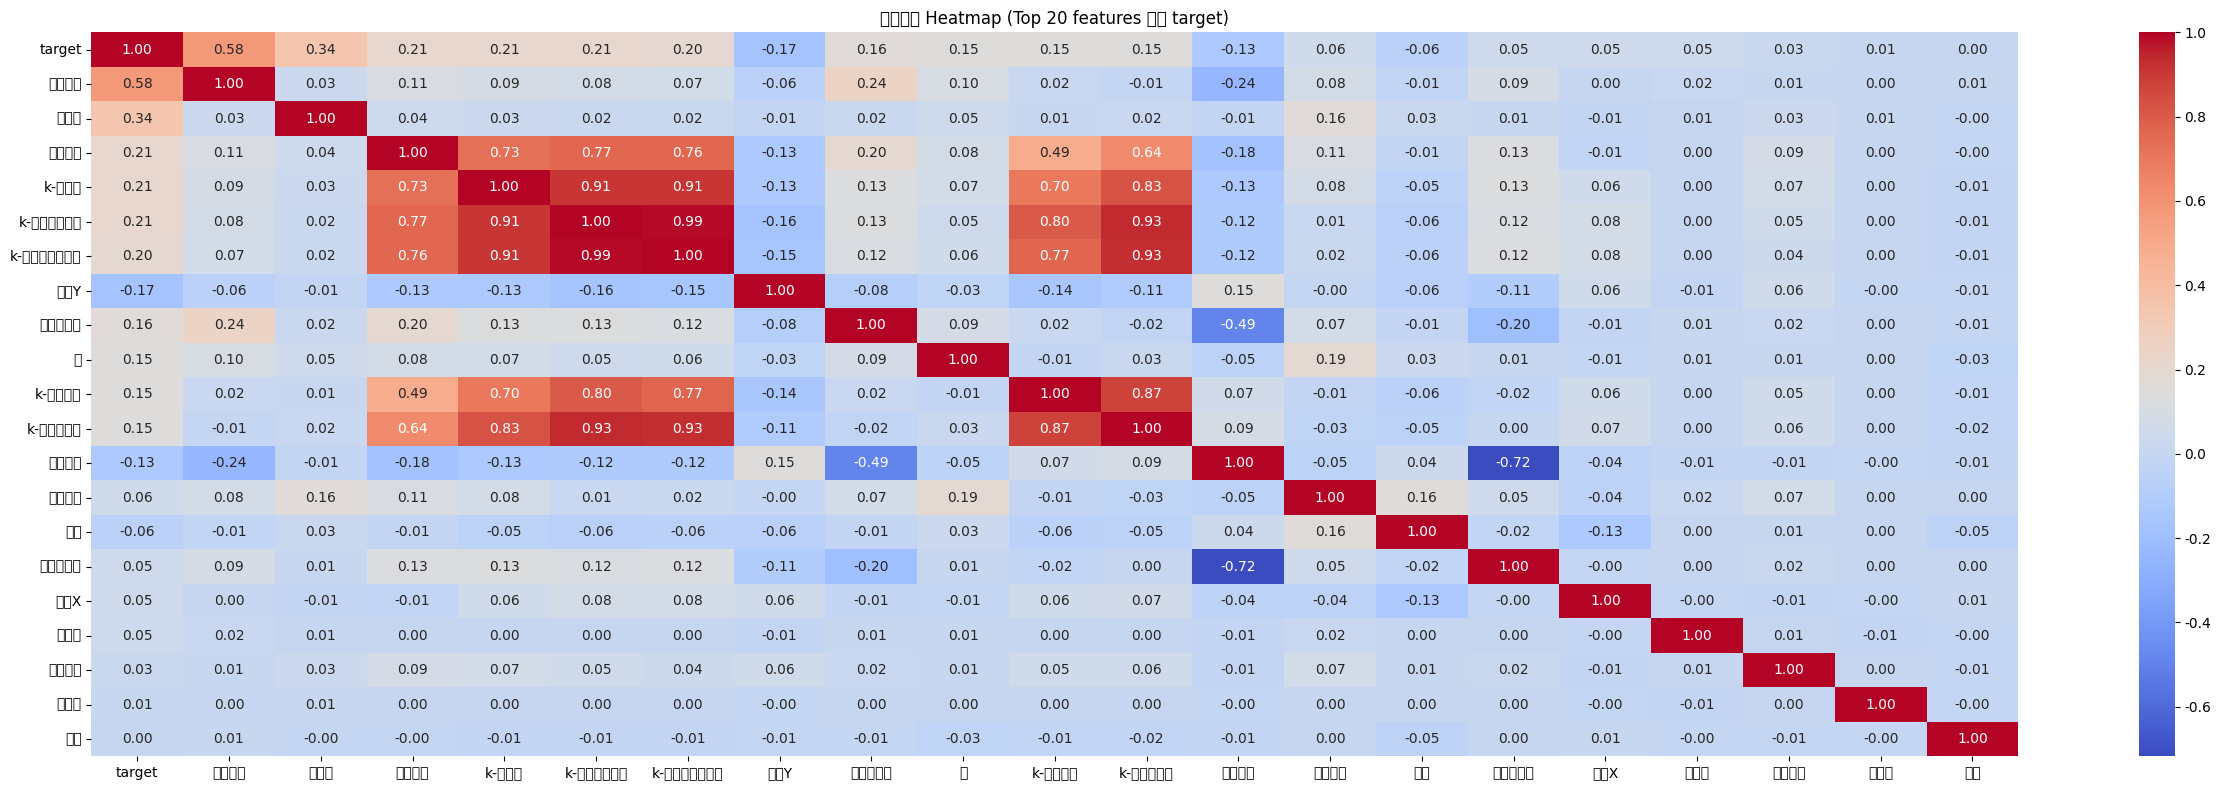

In [86]:
# 한글 폰트 설정
import matplotlib
matplotlib.rc('font', family='NanumGothic')  # 또는 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

def plot_corr_heatmap(df, target_col="target", train_flag_col="train_data", topn=20):
    """
    - train 데이터만 사용
    - 수치형 변수의 target과 상관관계 계산
    - 상위 N개 변수 + target으로 heatmap 시각화
    """
    # train만 필터링
    dtrain = df[df[train_flag_col] == 1].copy()
    
    # 수치형 변수만 선택
    num_cols = dtrain.select_dtypes(include=["number"]).columns.tolist()
    if target_col in num_cols:
        pass
    else:
        num_cols.append(target_col)

    # 결측치 중앙값 대체 (상관 안정화)
    dnum = dtrain[num_cols].copy()
    dnum = dnum.fillna(dnum.median())

    # 상관계수 행렬
    corr = dnum.corr()

    # target과 상관 높은 상위 N 변수 선택
    target_corr = corr[target_col].abs().sort_values(ascending=False)
    top_features = target_corr.head(topn+1).index.tolist()  # target 포함

    # Heatmap 그리기
    plt.figure(figsize=(1.2*len(top_features), 8))
    sns.heatmap(corr.loc[top_features, top_features], annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"상관관계 Heatmap (Top {topn} features 기준 {target_col})")
    plt.tight_layout()
    plt.show()

# ======================
# 사용 예시
# ======================
plot_corr_heatmap(train_main, target_col="target", train_flag_col="train_data", topn=20)

In [87]:
# 상관계수 확인 후 상관계수 높은 변수 확인 
train_main['k-주거전용면적'].value_counts()

470140.0    3068
242461.0    2816
537573.0    2605
353089.0    2592
117086.0    2480
            ... 
38716.0        2
24878.0        2
18236.0        2
22782.0        1
37677.0        1
Name: k-주거전용면적, Length: 740, dtype: int64

In [88]:
# 비슷한 변수 제거
train_main.drop(['k-관리비부과면적','k-주거전용면적',], axis=1, inplace =True)

In [90]:
# 신축여부 변수 생
train_main['신축여부'] = train_main['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [91]:
# 서울 집값 등급 변수 생성
price_group = {
    "강남구": 3, "서초구": 3, "송파구": 3, "용산구": 3,
    "마포구": 2, "성동구": 2, "광진구": 2, "동작구": 2, "양천구": 2, "강동구": 2,
}
train_main["서울집값등급"] = train_main["구"].map(price_group).fillna(1)

In [92]:
# 서울집값등급 value 확인
train_main['서울집값등급'].value_counts()

1.0    649133
2.0    260626
3.0    218335
Name: 서울집값등급, dtype: int64

In [93]:
# 좌표 변수 제거
train_main['경도'] =  train_main['좌표X']
train_main['위도'] =  train_main['좌표Y']
train_main.drop(['좌표X','좌표Y'], axis=1, inplace=True)

In [94]:
# 아파트명 value 확인
train_main['아파트명'].value_counts()

현대               16779
신동아              12929
한신                9128
두산                8593
주공2               7955
                 ...  
제니스뷰                 1
다온숲                  1
포렛빌                  1
DMC금호리첸시아            1
힐스테이트세운센트럴1단지        1
Name: 아파트명, Length: 6549, dtype: int64

In [95]:
# 아파트 브랜드 등급 변수 생성
import re
import pandas as pd

# === 1) 우선순위 패턴 목록 (위에서 아래로 매칭) ===
# (정규식 패턴, 등급)
PATTERN_GRADED = [

    # ---- 5등급: 최상위 랜드마크/초고가 ----
    (r'한남더힐', 5),
    (r'나인원\s*한남|Nine\s*One\s*Hannam', 5),
    (r'PH\s*129|PH129', 5),
    (r'아크로\s*서울\s*포레스트|Acro\s*Seoul\s*Forest', 5),
    (r'아크로\s*리버\s*파크|Acro\s*River\s*Park', 5),

    # ---- 4등급: 강남권 최상위/프리미엄 플래그십 ----
    (r'원\s*베일리|원베일리|래미안\s*원\s*베일리', 4),
    (r'반포\s*자이', 4),
    (r'래미안\s*퍼스티지', 4),
    (r'압구정.*현대|현대.*압구정', 4),
    (r'디\s*에이치|THE\s*H|The\s*H', 4),             # 현대 고급 브랜드 (예: 디에이치 아너힐즈 등)
    (r'트리마제|Trimage', 4),
    (r'라클래시|래미안\s*라\s*클래시|Raemian\s*Laclass', 4),

    # ---- 3등급: 메이저 브랜드 일반/강남권 대단지 ----
    (r'래미안|Raemian', 3),
    (r'자이|Xi\b', 3),
    (r'아이\s*파크|I-?PARK|IPARK', 3),
    (r'푸르지오|Prugio', 3),
    (r'더\s*샵|The\s*Sharp', 3),
    (r'e\s*편한\s*세상|e편한세상|e-?Pyeonhansesang', 3),
    (r'센트레빌', 3),
    (r'래대푸|마포\s*래미안\s*푸르지오', 3),
    (r'헬리오\s*시티|Helio\s*City', 3),
    (r'파크리오', 3),
    (r'올림픽\s*선수촌', 3),
    (r'잠실\s*(리센츠|엘스|트리지움)', 3),

    # ---- 2등급: 준메이저/중상 브랜드, 대중적 신축/재건축 ----
    (r'힐스테이트|Hillstate', 2),
    (r'롯데\s*캐슬|Lotte\s*Castle', 2),
    (r'위브|We\'?ve', 2),
    (r'호반\s*(써밋|베르디움)', 2),
    (r'경남\s*아너스빌|아너스빌', 2),
    (r'두산', 2),
    (r'금호', 2),
    (r'벽산', 2),
    (r'현대\s*홈\s*타운', 2),

    # ---- 1등급: 기타/브랜드 미표기/중소 ----
    # 매칭 없으면 1로 처리
]

def brand_grade_from_name(name: str) -> int:
    """아파트명 문자열에서 브랜드/단지 키워드를 정규식으로 찾아 5~1등급 반환."""
    if pd.isna(name):
        return 1
    s = str(name).strip()
    # 공백/하이픈/대소문자 변형 허용을 위한 전처리(선택): 여기서는 정규식이 유연해서 생략 가능
    for pattern, grade in PATTERN_GRADED:
        if re.search(pattern, s, flags=re.IGNORECASE):
            return int(grade)
    return 1

# 사용 예시
train_main['apt_grade'] = train_main['아파트명'].apply(brand_grade_from_name).astype(int)



In [96]:
# 아파트 브랜드 등급 value 확인
train_main['apt_grade'].value_counts()

1    885881
3    130142
2    106683
4      4218
5      1170
Name: apt_grade, dtype: int64

In [97]:
# apt_grade 1~5 -> 1,2,3(보통),3(보통),3(보통) 으로 변환
bins_map_A = {1:1, 2:2, 3:3, 4:3, 5:3}
train_main['apt_grade_bin_A'] = train_main['apt_grade'].map(bins_map_A).astype('Int64')

train_main['is_ultra_premium'] = train_main['apt_grade'].isin([4,5]).astype(int)
# apt_grade 자체(1~5) + is_ultra_premium(0/1) 병행


In [98]:
# 아파트명 변수 제거
train_main.drop('apt_grade',axis=1, inplace=True)

In [99]:
# 불필요한 변수 제거
train_main.drop(['번지','본번','아파트명', '부번', '도로명', '거래유형'],axis=1, inplace=True)

In [100]:
# 건설사 value 확인
train_main['k-건설사(시공사)'].value_counts()

삼성물산         14259
대우건설         11549
현대건설         10575
대한주택공사        7665
GS건설          7015
             ...  
두산               5
신영건설             3
자이에스앤디(주)        2
혜림건설             1
삼익건설(주)          1
Name: k-건설사(시공사), Length: 344, dtype: int64

In [101]:
# 건설사 변수 생성
# 건설사 등급 점수 매핑 (3: 대형, 2: 중견, 1: 기타)
company_score_3 = {
    '삼성물산': 3,
    '현대건설': 3,
    'GS건설': 3,
    'DL이앤씨': 2,
    'HDC현대산업개발': 2,
    '대우건설': 2,
    '포스코건설': 2,
    '롯데건설': 2,
    '호반건설': 1,
    '금호건설': 1,
    '쌍용건설': 1,
    '두산건설': 1,
}

def match_company_score(name: str) -> int:
    if pd.isna(name):
        return 1  # 결측치 -> 기타
    for comp, score in company_score_3.items():
        if re.search(comp, str(name)):
            return score
    return 1  # 어떤 회사명도 매칭 안 되면 '기타' = 1

train_main['건설사구분'] = train_main['k-건설사(시공사)'].apply(match_company_score).astype(int)


In [102]:
# 수치형, 범주형 변수 구분 재확인
continuous_columns= []
categorical_columns = []
for column in train_main.columns:
    if pd.api.types.is_numeric_dtype(train_main[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)
print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', '건축면적', '주차대수', 'target', 'train_data', '계약년', '계약월', '소형비율', '중소형비율', '중대형비율', '신축여부', '서울집값등급', '경도', '위도', 'apt_grade_bin_A', 'is_ultra_premium', '건설사구분']
범주형 변수: ['k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '단지신청일', '구', '동']


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

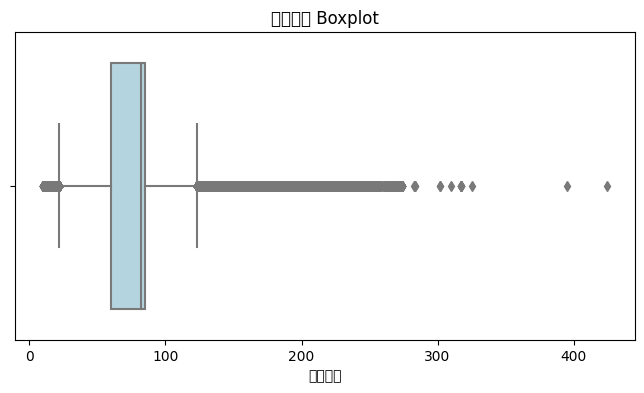

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

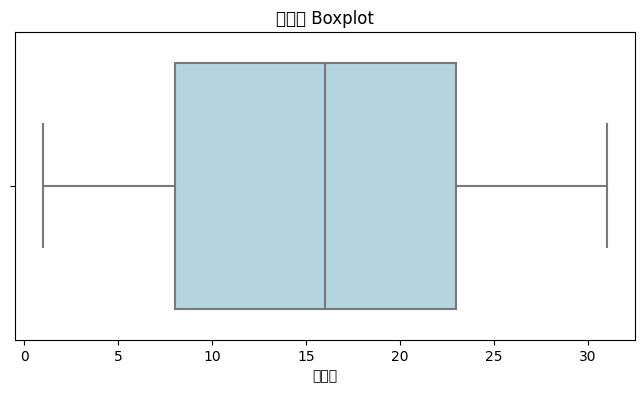

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

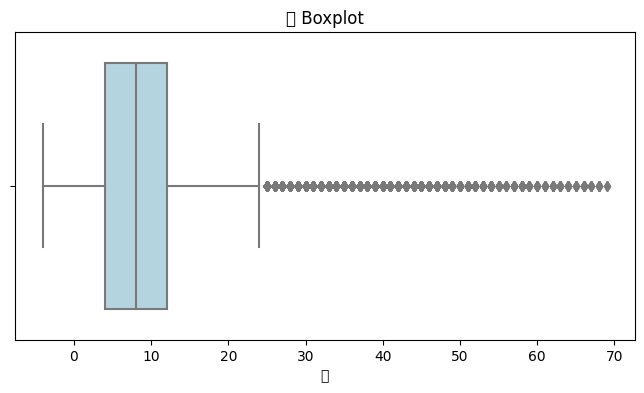

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

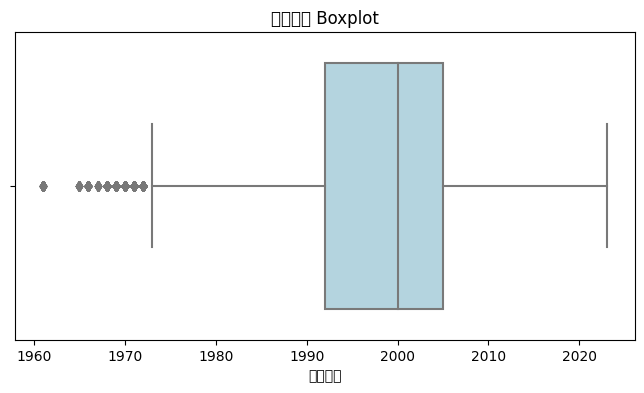

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

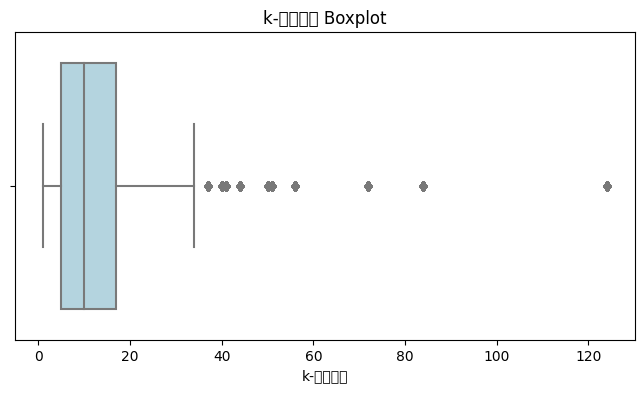

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

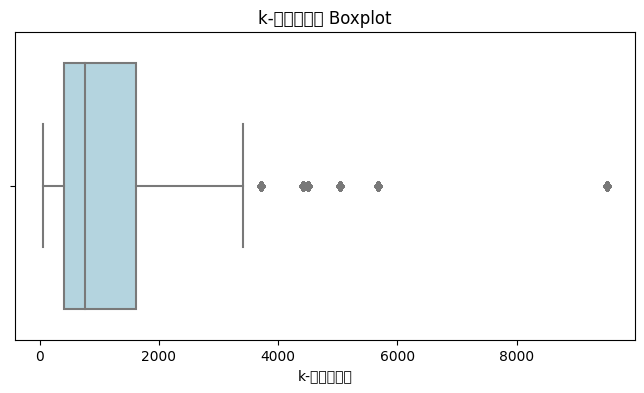

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

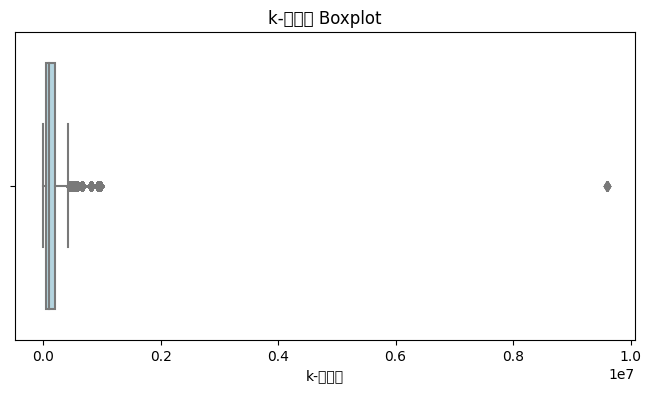

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

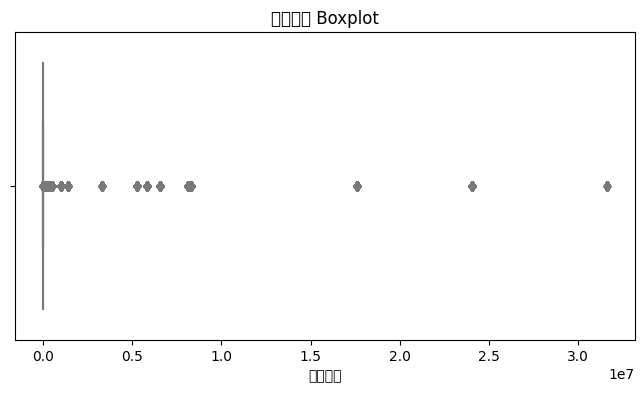

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

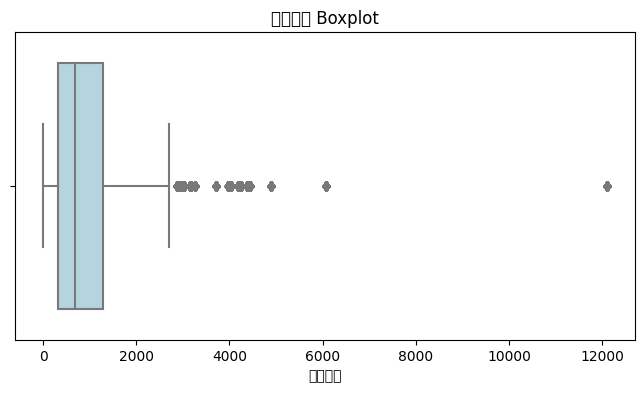

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

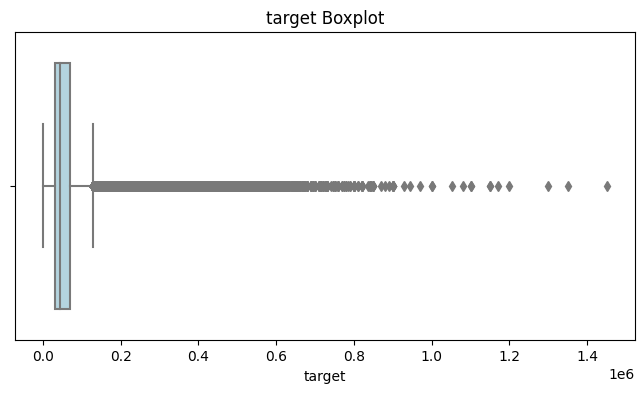

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

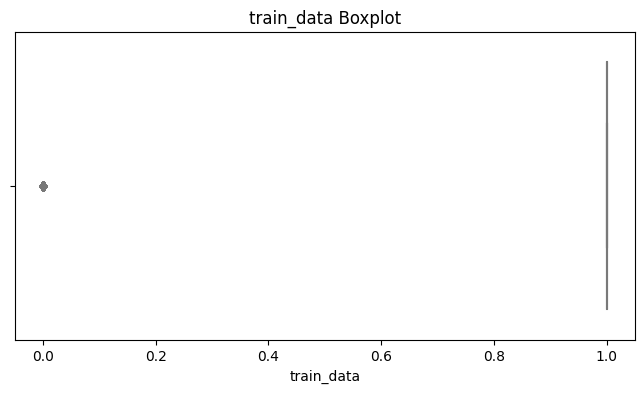

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

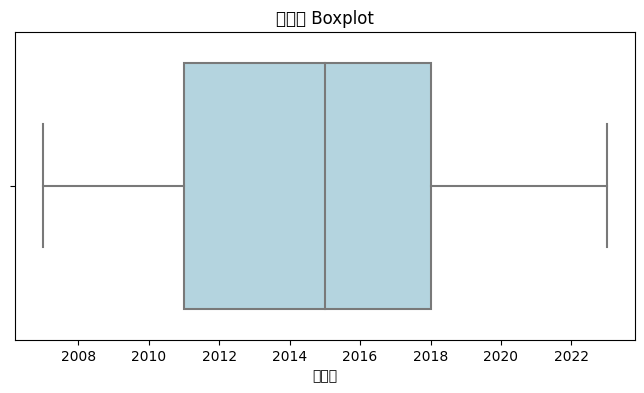

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

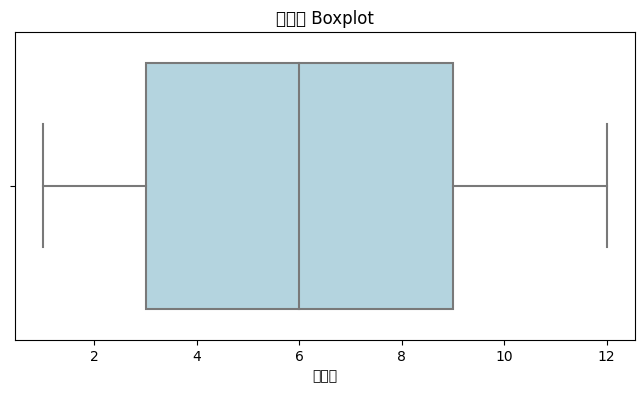

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

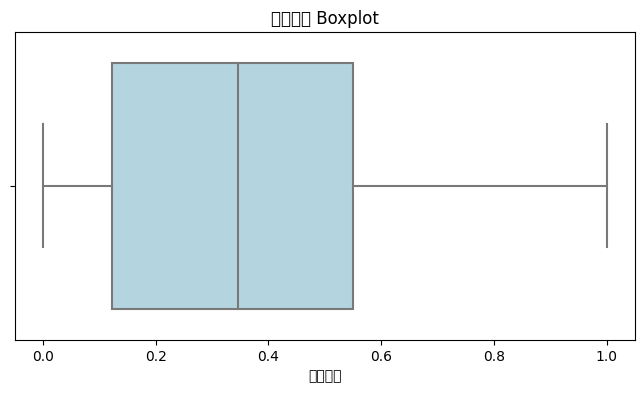

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

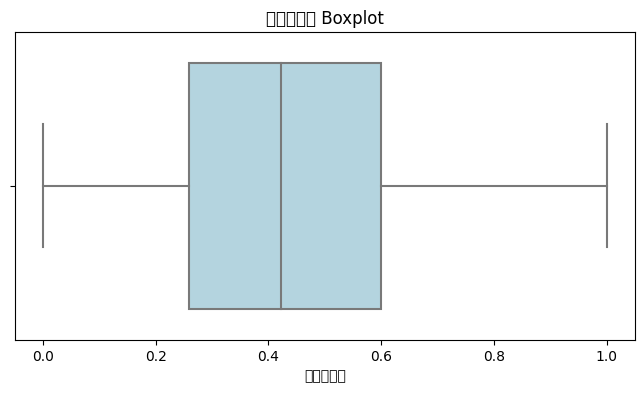

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

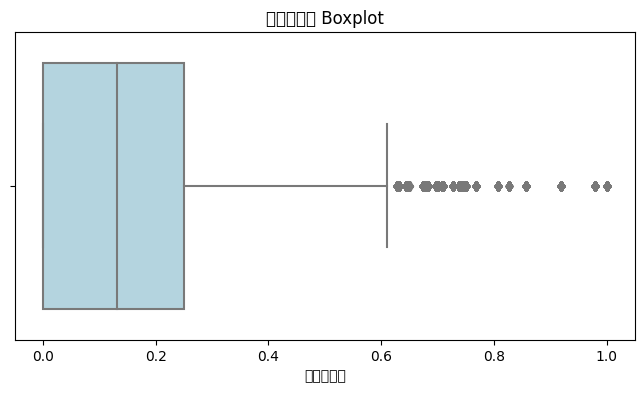

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

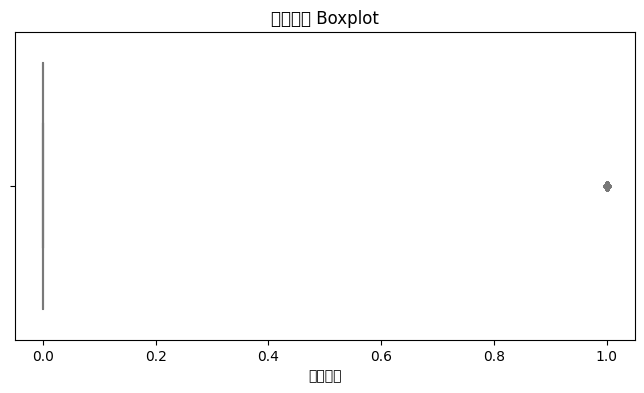

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

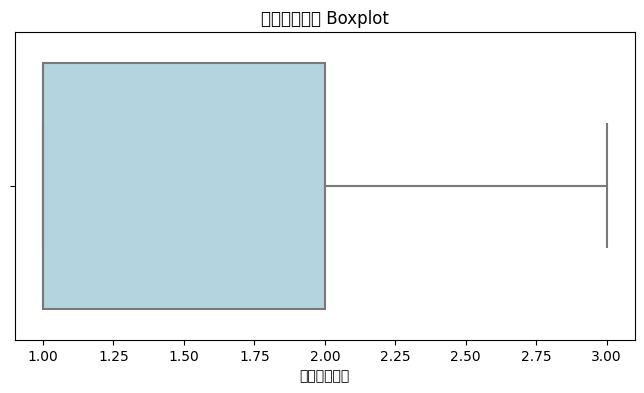

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

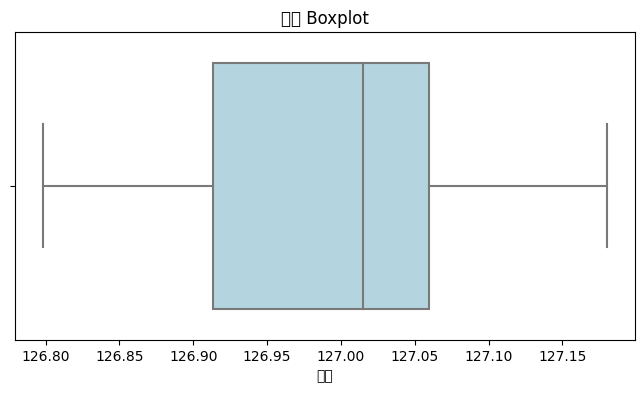

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

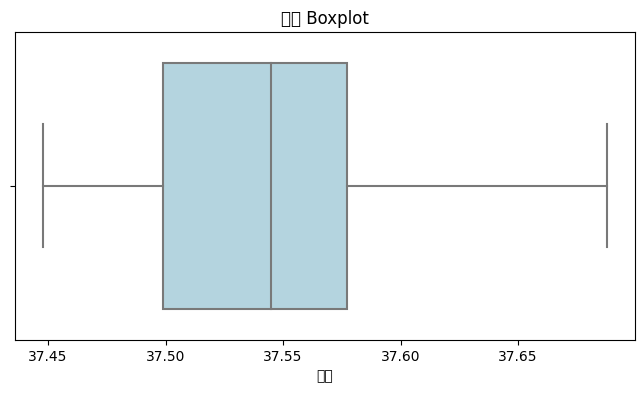

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

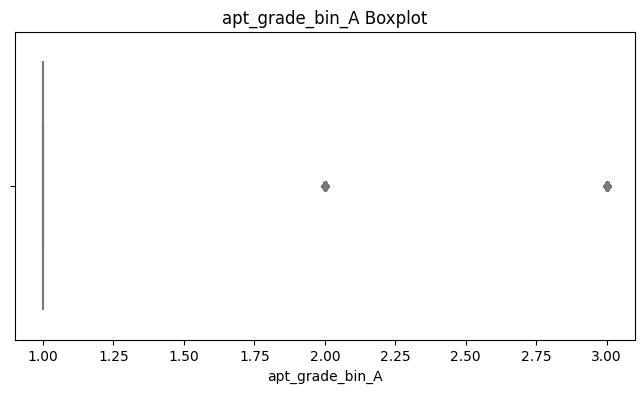

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

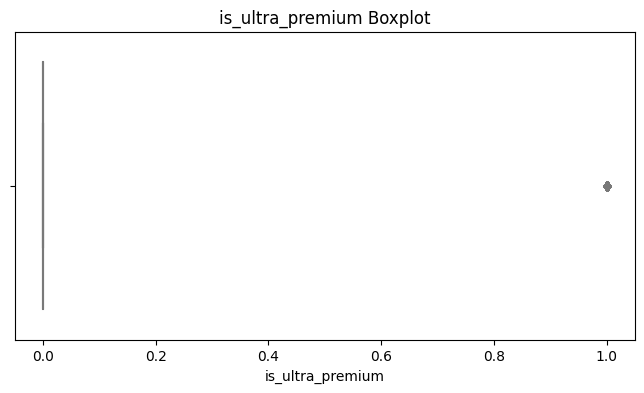

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

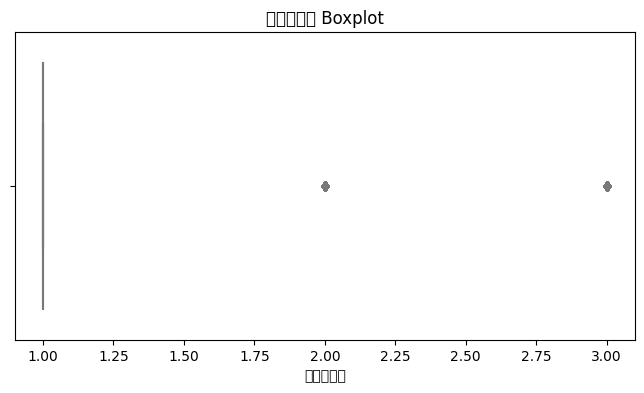

In [103]:
import matplotlib

matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 연속형 변수 시각화
for col in continuous_columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=train_main, x=col, color="lightblue")
    plt.title(f"{col} Boxplot")
    plt.show()

In [104]:
# 통계값 확인
train_main.describe()

,전용면적,계약일,층,건축년도,k-전체동수,k-전체세대수,k-연면적,건축면적,주차대수,target,...,소형비율,중소형비율,중대형비율,신축여부,서울집값등급,경도,위도,apt_grade_bin_A,is_ultra_premium,건설사구분
count,1.128094e+06,1.128094e+06,1.128094e+06,1.128094e+06,250887.000000,251969.000000,2.519690e+05,2.518150e+05,251817.000000,1.118822e+06,...,250483.000000,250483.000000,250483.000000,1.128094e+06,1.128094e+06,251862.000000,251862.000000,1128094.0,1.128094e+06,1.128094e+06
mean,7.716028e+01,1.579966e+01,8.881412e+00,1.998791e+03,14.810871,1186.767436,1.619010e+05,1.904915e+05,1068.300798,5.799153e+04,...,0.390753,0.429199,0.179713,1.347875e-01,1.618119e+00,126.995315,37.545760,1.334851,4.776198e-03,1.119344e+00
std,2.936448e+01,8.722162e+00,5.989302e+00,9.358540e+00,17.682771,1197.452046,1.843113e+05,1.735029e+06,1247.315587,4.642602e+04,...,0.330945,0.288302,0.231895,3.414966e-01,7.893890e-01,0.091001,0.052457,0.680447,6.894483e-02,4.465660e-01
min,1.002000e+01,1.000000e+00,-4.000000e+00,1.961000e+03,1.000000,59.000000,0.000000e+00,0.000000e+00,0.000000,3.500000e+02,...,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,126.798318,37.447843,1.0,0.000000e+00,1.000000e+00
25%,5.965000e+01,8.000000e+00,4.000000e+00,1.992000e+03,5.000000,405.000000,5.366600e+04,0.000000e+00,316.000000,3.050000e+04,...,0.122302,0.259372,0.000000,0.000000e+00,1.000000e+00,126.913157,37.498830,1.0,0.000000e+00,1.000000e+00
50%,8.187000e+01,1.600000e+01,8.000000e+00,2.000000e+03,10.000000,768.000000,1.026240e+05,1.735000e+03,683.000000,4.480000e+04,...,0.345616,0.422018,0.131455,0.000000e+00,1.000000e+00,127.014971,37.544936,1.0,0.000000e+00,1.000000e+00
75%,8.496000e+01,2.300000e+01,1.200000e+01,2.005000e+03,17.000000,1622.000000,2.039040e+05,8.414210e+03,1284.000000,6.980000e+04,...,0.550380,0.600000,0.250000,0.000000e+00,2.000000e+00,127.059590,37.577117,1.0,0.000000e+00,1.000000e+00
max,4.243200e+02,3.100000e+01,6.900000e+01,2.023000e+03,124.000000,9510.000000,9.591851e+06,3.159620e+07,12096.000000,1.450000e+06,...,1.000000,1.000000,1.000000,1.000000e+00,3.000000e+00,127.179998,37.687725,3.0,1.000000e+00,3.000000e+00


In [106]:
# 결측치 0으로 채우기
cols = [
    "층",
    "k-전체동수",
    "k-전체세대수",
    "k-연면적",
    "전용면적",
    "주차대수",
    '건축면적'
]
train_main[col].fillna(0, inplace=True)


In [107]:
# 0이상인 수치형 변수들에 log1p 변환 적용
log_cols = [
    "층",
    "k-전체동수",
    "k-전체세대수",
    "k-연면적",
    "전용면적",
    "주차대수",
    '건축면적'
]

# 새로운 컬럼명은 _log를 붙여서 추가
for col in log_cols:
    if col in train_main.columns:
        # 음수/0 방지: 0보다 작은 값은 0으로 클리핑 후 log1p 적용
        train_main[col + "_log"] = np.log1p(train_main[col].clip(lower=0))

In [108]:
# 로그 변환한 컬럼 리스트
log_cols = [
    "층_log",
    "k-전체동수_log",
    "k-전체세대수_log",
    "k-연면적_log",
    "전용면적_log",
    "주차대수_log",
    "건축면적_log"
]

# 0값 비율 확인
zero_check = {}
for col in log_cols:
    if col in train_main.columns:
        zero_ratio = (train_main[col] == 0).mean()
        zero_count = (train_main[col] == 0).sum()
        zero_check[col] = {"zero_count": zero_count, "zero_ratio": round(zero_ratio, 4)}

zero_report = pd.DataFrame(zero_check).T.sort_values("zero_ratio", ascending=False)
print("로그 변환 컬럼별 0값 현황")
display(zero_report)

로그 변환 컬럼별 0값 현황


,zero_count,zero_ratio
건축면적_log,118394.0,0.1050
주차대수_log,18141.0,0.0161
k-연면적_log,1082.0,0.0010
층_log,264.0,0.0002
k-전체동수_log,0.0,0.0000
k-전체세대수_log,0.0,0.0000
전용면적_log,0.0,0.0000


In [109]:
# 로그변환한 컬럼 제외한 기존 컬럼 제거
train_main.drop(cols, axis=1, inplace=True)

In [110]:
# 통계값 확인
train_main.describe()

,계약일,건축년도,target,train_data,계약년,계약월,소형비율,중소형비율,중대형비율,신축여부,...,apt_grade_bin_A,is_ultra_premium,건설사구분,층_log,k-전체동수_log,k-전체세대수_log,k-연면적_log,전용면적_log,주차대수_log,건축면적_log
count,1.128094e+06,1.128094e+06,1.118822e+06,1.128094e+06,1.128094e+06,1.128094e+06,250483.000000,250483.000000,250483.000000,1.128094e+06,...,1128094.0,1.128094e+06,1.128094e+06,1.128094e+06,250887.000000,251969.000000,251969.000000,1.128094e+06,251817.000000,251815.000000
mean,1.579966e+01,1.998791e+03,5.799153e+04,9.917808e-01,2.014765e+03,6.322829e+00,0.390753,0.429199,0.179713,1.347875e-01,...,1.334851,4.776198e-03,1.119344e+00,2.093839e+00,2.360534,6.674074,11.504140,4.288214e+00,6.023942,4.863562
std,8.722162e+00,9.358540e+00,4.642602e+04,9.028635e-02,4.237117e+00,3.306039e+00,0.330945,0.288302,0.231895,3.414966e-01,...,0.680447,6.894483e-02,4.465660e-01,6.604246e-01,0.875434,0.901249,1.207740,3.895357e-01,2.104851,4.743497
min,1.000000e+00,1.961000e+03,3.500000e+02,0.000000e+00,2.007000e+03,1.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,...,1.0,0.000000e+00,1.000000e+00,0.000000e+00,0.693147,4.094345,0.000000,2.399712e+00,0.000000,0.000000
25%,8.000000e+00,1.992000e+03,3.050000e+04,1.000000e+00,2.011000e+03,3.000000e+00,0.122302,0.259372,0.000000,0.000000e+00,...,1.0,0.000000e+00,1.000000e+00,1.609438e+00,1.791759,6.006353,10.890554,4.105120e+00,5.758902,0.000000
50%,1.600000e+01,2.000000e+03,4.480000e+04,1.000000e+00,2.015000e+03,6.000000e+00,0.345616,0.422018,0.131455,0.000000e+00,...,1.0,0.000000e+00,1.000000e+00,2.197225e+00,2.397895,6.645091,11.538837,4.417273e+00,6.527958,7.459339
75%,2.300000e+01,2.005000e+03,6.980000e+04,1.000000e+00,2.018000e+03,9.000000e+00,0.550380,0.600000,0.250000,0.000000e+00,...,1.0,0.000000e+00,1.000000e+00,2.564949e+00,2.890372,7.392032,12.225409,4.453882e+00,7.158514,9.037796
max,3.100000e+01,2.023000e+03,1.450000e+06,1.000000e+00,2.023000e+03,1.200000e+01,1.000000,1.000000,1.000000,1.000000e+00,...,3.0,1.000000e+00,3.000000e+00,4.248495e+00,4.828314,9.160204,16.076425,6.052842e+00,9.400713,17.268547


In [111]:
# 로그변환한 컬럼 value 확인
train_main['건축면적_log'].value_counts()

0.000000     118394
10.805018      2605
12.057410      2480
10.155724      2366
9.926169       2208
              ...  
8.722073          2
8.727888          2
7.910393          2
8.753149          2
7.975956          1
Name: 건축면적_log, Length: 455, dtype: int64

In [112]:
# 결측치 확인
train_main.isnull().sum().sort_values(ascending=False)

세대전기계약방법               885389
청소비관리형태                877751
k-건설사(시공사)             877637
소형비율                   877611
중대형비율                  877611
중소형비율                  877611
경비비관리형태                877561
k-단지분류(아파트,주상복합등등)     877273
k-전체동수_log             877207
단지승인일                  876854
k-복도유형                 876454
건축면적_log               876279
주차대수_log               876277
k-사용검사일-사용승인일          876259
경도                     876232
위도                     876232
단지신청일                  876187
기타/의무/임대/임의=1/2/3/4    876125
k-연면적_log              876125
k-전체세대수_log            876125
k-난방방식                 876125
k-관리방식                 876125
k-세대타입(분양형태)           876125
target                   9272
is_ultra_premium            0
전용면적_log                    0
층_log                       0
건설사구분                       0
서울집값등급                      0
apt_grade_bin_A             0
신축여부                        0
동                           0
구                           0
건축년도      

In [113]:
# 결측치가 많은 '건축면적_log' 컬럼 제거
train_main.drop('건축면적_log', axis=1, inplace=True)

In [114]:
# 0값 비율 확인
all = list(train_main['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)

In [115]:
# 강남여부 변수 생성
is_gangnam = []
for x in train_main['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
train_main['강남여부'] = is_gangnam

In [116]:
# 신축여부 변수 생성
train_main['신축여부'] = train_main['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [117]:
# 버스 데이터 확인
bus.head(1)

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로


In [118]:
# 지하철 데이터 확인
subway.head(1)

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877


In [119]:
# columns 이름 변경
bus.columns = ['노드ID', '정류소번호', '정류소명', '경도', '위도', '정류소 타입' ]

In [120]:
train_main.columns

Index(['계약일', '건축년도', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-건설사(시공사)', 'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법',
       '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '단지신청일', 'target',
       'train_data', '계약년', '계약월', '소형비율', '중소형비율', '중대형비율', '구', '동', '신축여부',
       '서울집값등급', '경도', '위도', 'apt_grade_bin_A', 'is_ultra_premium', '건설사구분',
       '층_log', 'k-전체동수_log', 'k-전체세대수_log', 'k-연면적_log', '전용면적_log',
       '주차대수_log', '강남여부'],
      dtype='object')

In [121]:
# 위도, 경도 좌표계산 (BallTree)
from sklearn.neighbors import BallTree

# ===== 파라미터 =====
BUS_LIMIT_M = 300          # 500~800m 중 네가 원하는 값으로 변경
EARTH_RADIUS_KM = 6371.0

# ===== 입력 =====
# train: 집 좌표가 들어있는 DF, 컬럼명 예시 ['위도','경도']
# subway: 지하철역 DF, 컬럼명 예시 ['역사명','위도','경도']
# 결측/비정상 좌표 제거 (선택)
train_ = train_main.dropna(subset=['위도','경도']).copy()
bus_ = bus.dropna(subset=['위도','경도']).copy()

# ===== 라디안 변환 =====
train_coords_rad  = np.radians(train_[['위도','경도']].values)
bus_coords_rad = np.radians(bus_[['위도','경도']].values)

# ===== BallTree (하버사인) =====
tree = BallTree(bus_coords_rad, metric='haversine')

# 반경(m) -> 라디안
radius_rad = (BUS_LIMIT_M / 1000.0) / EARTH_RADIUS_KM

# 반경 내 존재 여부 (binary)
inside_indices = tree.query_radius(train_coords_rad, r=radius_rad)
train_['bus_nearby'] = [1 if len(idxs) > 0 else 0 for idxs in inside_indices]

# 가장 가까운 지하철역까지의 거리(미터) & 이름(옵션)
# BallTree.query 반환 거리 단위: 라디안 -> m 로 변환
dist_rad, ind = tree.query(train_coords_rad, k=1)
nearest_dist_m = dist_rad[:, 0] * EARTH_RADIUS_KM * 1000.0
nearest_idx = ind[:, 0]

train_['nearest_bus_dist_m'] = nearest_dist_m.round(1)
train_['nearest_bus_name'] = bus_.iloc[nearest_idx]['정류소명'].values


train_main[['bus_nearby','nearest_bus_dist_m','nearest_bus_name']] = \
    train_.reindex(train_main.index)[['bus_nearby','nearest_bus_dist_m','nearest_bus_name']]



In [122]:
# ===== 파라미터 =====
SUBWAY_LIMIT_M = 800
EARTH_RADIUS_KM = 6371.0

# ===== 좌표 숫자화 & 결측 제거 =====
for df in (train_main, subway):
    df[['위도','경도']] = df[['위도','경도']].apply(pd.to_numeric, errors='coerce')

train_  = train_main.dropna(subset=['위도','경도']).copy()
subway_ = subway.dropna(subset=['위도','경도']).copy()

# ===== 라디안 변환 (반드시 [위도, 경도] 순서) =====
train_coords_rad  = np.radians(train_[['위도','경도']].to_numpy())
subway_coords_rad = np.radians(subway_[['위도','경도']].to_numpy())

# ===== BallTree (haversine) =====
subway_tree = BallTree(subway_coords_rad, metric='haversine')

# 반경(m) -> 라디안
radius_rad = (SUBWAY_LIMIT_M / 1000.0) / EARTH_RADIUS_KM

# 반경 내 존재 여부 (binary)
inside_indices = subway_tree.query_radius(train_coords_rad, r=radius_rad)
train_['subway_nearby'] = np.fromiter((len(ix) > 0 for ix in inside_indices), dtype=int, count=len(train_))

# 가장 가까운 지하철역까지의 거리(미터) & 이름
# query 반환 거리는 라디안 -> 미터로 변환
dist_rad, ind = subway_tree.query(train_coords_rad, k=1)
nearest_dist_m = dist_rad[:, 0] * EARTH_RADIUS_KM * 1000.0
nearest_idx    = ind[:, 0]

train_['nearest_subway_dist_m'] = nearest_dist_m.round(1)
train_['nearest_subway_name']   = subway_.iloc[nearest_idx]['역사명'].to_numpy()

# ===== 원본 인덱스에 정렬해서 할당 =====
cols = ['subway_nearby','nearest_subway_dist_m','nearest_subway_name']
train_main[cols] = train_.reindex(train_main.index)[cols]

In [123]:
train_main


,계약일,건축년도,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-건설사(시공사),k-사용검사일-사용승인일,경비비관리형태,...,k-연면적_log,전용면적_log,주차대수_log,강남여부,bus_nearby,nearest_bus_dist_m,nearest_bus_name,subway_nearby,nearest_subway_dist_m,nearest_subway_name
0,8,1987,아파트,분양,자치관리,계단식,개별난방,우성건설,1987-11-21 00:00:00.0,직영,...,10.027385,4.394079,5.572154,1,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
1,22,1987,아파트,분양,자치관리,계단식,개별난방,우성건설,1987-11-21 00:00:00.0,직영,...,10.027385,4.394079,5.572154,1,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
2,28,1987,아파트,분양,자치관리,계단식,개별난방,우성건설,1987-11-21 00:00:00.0,직영,...,10.027385,4.024994,5.572154,1,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
3,3,1987,아파트,분양,자치관리,계단식,개별난방,우성건설,1987-11-21 00:00:00.0,직영,...,10.027385,4.394079,5.572154,1,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
4,8,1987,아파트,분양,자치관리,계단식,개별난방,우성건설,1987-11-21 00:00:00.0,직영,...,10.027385,4.394079,5.572154,1,1.0,61.8,개포우성아파트,0.0,1129.8,구룡
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,19,2014,아파트,기타,위탁관리,혼합식,개별난방,한신공영(주),2014-06-18 00:00:00.0,위탁,...,12.159332,4.450269,7.358194,0,1.0,59.5,우디안아파트114동앞,1.0,733.3,신내
1128090,25,2014,아파트,기타,위탁관리,혼합식,개별난방,한신공영(주),2014-06-18 00:00:00.0,위탁,...,12.159332,4.449919,7.358194,0,1.0,59.5,우디안아파트114동앞,1.0,733.3,신내
1128091,27,2014,아파트,기타,위탁관리,혼합식,개별난방,한신공영(주),2014-06-18 00:00:00.0,위탁,...,12.159332,4.631325,7.358194,0,1.0,59.5,우디안아파트114동앞,1.0,733.3,신내
1128092,2,2014,아파트,기타,위탁관리,혼합식,개별난방,한신공영(주),2014-06-18 00:00:00.0,위탁,...,12.159332,4.453649,7.358194,0,1.0,59.5,우디안아파트114동앞,1.0,733.3,신내


In [124]:
# 계약년 value 확인
train_main['계약년'].value_counts()

2015    119891
2017    104893
2016     99253
2014     85130
2020     83711
2018     81413
2019     74696
2009     73491
2013     67865
2007     58767
2008     57012
2011     54513
2010     44457
2021     43117
2012     40851
2023     26820
2022     12214
Name: 계약년, dtype: int64

In [125]:
# 불필요한 변수 제거
train_main.drop(['k-사용검사일-사용승인일','k-건설사(시공사)','단지신청일','단지승인일','기타/의무/임대/임의=1/2/3/4','계약일','k-단지분류(아파트,주상복합등등)','k-세대타입(분양형태)','k-관리방식','경비비관리형태','세대전기계약방법',
                 '청소비관리형태'],axis=1, inplace=True)

In [126]:
train_main.columns

Index(['건축년도', 'k-복도유형', 'k-난방방식', 'target', 'train_data', '계약년', '계약월',
       '소형비율', '중소형비율', '중대형비율', '구', '동', '신축여부', '서울집값등급', '경도', '위도',
       'apt_grade_bin_A', 'is_ultra_premium', '건설사구분', '층_log', 'k-전체동수_log',
       'k-전체세대수_log', 'k-연면적_log', '전용면적_log', '주차대수_log', '강남여부',
       'bus_nearby', 'nearest_bus_dist_m', 'nearest_bus_name', 'subway_nearby',
       'nearest_subway_dist_m', 'nearest_subway_name'],
      dtype='object')

In [127]:
train_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128094 entries, 0 to 1128093
Data columns (total 32 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   건축년도                   1128094 non-null  int64  
 1   k-복도유형                 251640 non-null   object 
 2   k-난방방식                 251969 non-null   object 
 3   target                 1118822 non-null  float64
 4   train_data             1128094 non-null  int64  
 5   계약년                    1128094 non-null  int64  
 6   계약월                    1128094 non-null  int64  
 7   소형비율                   250483 non-null   float64
 8   중소형비율                  250483 non-null   float64
 9   중대형비율                  250483 non-null   float64
 10  구                      1128094 non-null  object 
 11  동                      1128094 non-null  object 
 12  신축여부                   1128094 non-null  int64  
 13  서울집값등급                 1128094 non-null  float64
 14  경도                

In [128]:
# 수치형, 범주형 변수 구분 재확인
continuous_columns= []
categorical_columns = []
for column in train_main.columns:
    if pd.api.types.is_numeric_dtype(train_main[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)
print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['건축년도', 'target', 'train_data', '계약년', '계약월', '소형비율', '중소형비율', '중대형비율', '신축여부', '서울집값등급', '경도', '위도', 'apt_grade_bin_A', 'is_ultra_premium', '건설사구분', '층_log', 'k-전체동수_log', 'k-전체세대수_log', 'k-연면적_log', '전용면적_log', '주차대수_log', '강남여부', 'bus_nearby', 'nearest_bus_dist_m', 'subway_nearby', 'nearest_subway_dist_m']
범주형 변수: ['k-복도유형', 'k-난방방식', '구', '동', 'nearest_bus_name', 'nearest_subway_name']


In [129]:
# 복제
train_origin = train_main.copy()

In [130]:
# 결측치 확인
train_main.isnull().sum().sort_values(ascending=False)

소형비율                     877611
중소형비율                    877611
중대형비율                    877611
k-전체동수_log               877207
k-복도유형                   876454
주차대수_log                 876277
nearest_subway_name      876232
위도                       876232
경도                       876232
bus_nearby               876232
nearest_bus_dist_m       876232
nearest_bus_name         876232
subway_nearby            876232
nearest_subway_dist_m    876232
k-난방방식                   876125
k-연면적_log                876125
k-전체세대수_log              876125
target                     9272
강남여부                          0
전용면적_log                      0
건축년도                          0
층_log                         0
건설사구분                         0
is_ultra_premium              0
서울집값등급                        0
신축여부                          0
동                             0
구                             0
계약월                           0
계약년                           0
train_data                    0
apt_grad

In [131]:
# 결측치 0으로 채우기  
# 일단 test 타겟값도 0으로 채우기
train_main = train_main.fillna(0)

In [132]:
# 최종 결측치 확인
train_main.isnull().sum().sort_values(ascending=False)

건축년도                     0
k-복도유형                   0
nearest_subway_dist_m    0
subway_nearby            0
nearest_bus_name         0
nearest_bus_dist_m       0
bus_nearby               0
강남여부                     0
주차대수_log                 0
전용면적_log                 0
k-연면적_log                0
k-전체세대수_log              0
k-전체동수_log               0
층_log                    0
건설사구분                    0
is_ultra_premium         0
apt_grade_bin_A          0
위도                       0
경도                       0
서울집값등급                   0
신축여부                     0
동                        0
구                        0
중대형비율                    0
중소형비율                    0
소형비율                     0
계약월                      0
계약년                      0
train_data               0
target                   0
k-난방방식                   0
nearest_subway_name      0
dtype: int64

In [133]:
# 최종 데이터프레임 복제
df = train_main.copy()

# 원본 컬럼 (질문에서 준 순서)
base_cols = [
    '건축년도','k-복도유형','k-난방방식','계약년','계약월','소형비율','중소형비율','중대형비율',
    '구','동','신축여부','서울집값등급','경도','위도','apt_grade_bin_A',
    'is_ultra_premium','건설사구분','층_log','k-전체동수_log','k-전체세대수_log',
    'k-연면적_log','전용면적_log','주차대수_log','강남여부','bus_nearby',
    'nearest_bus_dist_m','nearest_bus_name','subway_nearby',
    'nearest_subway_dist_m','nearest_subway_name','train_data','target'
]
# 실제 존재하는 것만 사용(안전)
base_cols = [c for c in base_cols if c in df.columns]
df = df[base_cols].copy()


In [134]:
# 인코딩 및 스케일링
# 파생
if {'계약년','건축년도'}.issubset(df.columns):
    df['건물연차'] = (df['계약년'] - df['건축년도']).clip(lower=0, upper=100)
else:
    df['건물연차'] = np.nan

if '계약월' in df.columns:
    df['계약월_sin'] = np.sin(2*np.pi*df['계약월']/12)
    df['계약월_cos'] = np.cos(2*np.pi*df['계약월']/12)
else:
    df['계약월_sin'] = np.nan
    df['계약월_cos'] = np.nan

# '동' → 빈도 인코딩 (고카디널리티 방지)
if '동' in df.columns:
    dong_freq = df['동'].value_counts(normalize=True)
    df['동_freq'] = df['동'].map(dong_freq).astype(float)
else:
    df['동_freq'] = np.nan

# 이름 컬럼 드랍
for c in ['nearest_bus_name','nearest_subway_name']:
    if c in df.columns:
        df.drop(columns=c, inplace=True)


In [135]:
# shape 확인
# train, test 분리
df_test = df.query('train_data==0')
df_train = df.query('train_data==1')

df_train.drop(['train_data'], axis=1, inplace=True)
df_test.drop(['train_data'], axis=1, inplace= True)
df_train.shape, df_test.shape

((1118822, 33), (9272, 33))

In [136]:
df_train

,건축년도,k-복도유형,k-난방방식,계약년,계약월,소형비율,중소형비율,중대형비율,구,동,...,강남여부,bus_nearby,nearest_bus_dist_m,subway_nearby,nearest_subway_dist_m,target,건물연차,계약월_sin,계약월_cos,동_freq
0,1987,계단식,개별난방,2017,12,0.074074,0.925926,0.000000,강남구,개포동,...,1,1.0,61.8,0.0,1129.8,124000.0,30,-2.449294e-16,1.000000e+00,0.010911
1,1987,계단식,개별난방,2017,12,0.074074,0.925926,0.000000,강남구,개포동,...,1,1.0,61.8,0.0,1129.8,123500.0,30,-2.449294e-16,1.000000e+00,0.010911
2,1987,계단식,개별난방,2017,12,0.074074,0.925926,0.000000,강남구,개포동,...,1,1.0,61.8,0.0,1129.8,91500.0,30,-2.449294e-16,1.000000e+00,0.010911
3,1987,계단식,개별난방,2018,1,0.074074,0.925926,0.000000,강남구,개포동,...,1,1.0,61.8,0.0,1129.8,130000.0,31,5.000000e-01,8.660254e-01,0.010911
4,1987,계단식,개별난방,2018,1,0.074074,0.925926,0.000000,강남구,개포동,...,1,1.0,61.8,0.0,1129.8,117000.0,31,5.000000e-01,8.660254e-01,0.010911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,1998,혼합식,개별난방,2007,7,0.467213,0.385246,0.147541,은평구,구산동,...,0,1.0,79.6,0.0,1039.6,20000.0,9,-5.000000e-01,-8.660254e-01,0.002034
1118818,1998,혼합식,개별난방,2007,8,0.467213,0.385246,0.147541,은평구,구산동,...,0,1.0,79.6,0.0,1039.6,20000.0,9,-8.660254e-01,-5.000000e-01,0.002034
1118819,1998,혼합식,개별난방,2007,8,0.467213,0.385246,0.147541,은평구,구산동,...,0,1.0,79.6,0.0,1039.6,28000.0,9,-8.660254e-01,-5.000000e-01,0.002034
1118820,1998,혼합식,개별난방,2007,9,0.467213,0.385246,0.147541,은평구,구산동,...,0,1.0,79.6,0.0,1039.6,29000.0,9,-1.000000e+00,-1.836970e-16,0.002034


In [137]:
# 수치형, 범주형 변수 구분 재확인
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['건축년도', '계약년', '계약월', '소형비율', '중소형비율', '중대형비율', '신축여부', '서울집값등급', '경도', '위도', 'apt_grade_bin_A', 'is_ultra_premium', '건설사구분', '층_log', 'k-전체동수_log', 'k-전체세대수_log', 'k-연면적_log', '전용면적_log', '주차대수_log', '강남여부', 'bus_nearby', 'nearest_bus_dist_m', 'subway_nearby', 'nearest_subway_dist_m', 'target', '건물연차', '계약월_sin', '계약월_cos', '동_freq']
범주형 변수: ['k-복도유형', 'k-난방방식', '구', '동']


In [138]:
# 라벨 인코
label_encoders = {}
for col in categorical_columns_v2:
    df_train[col] = df_train[col].astype("string").fillna("__NA__")
    df_test[col]  = df_test[col].astype("string").fillna("__NA__")

    lbl = LabelEncoder()
    lbl.fit(pd.concat([df_train[col], df_test[col]], axis=0))

    df_train[col] = lbl.transform(df_train[col])
    df_test[col]  = lbl.transform(df_test[col])
    label_encoders[col] = lbl


In [139]:
# 잘 됐는지 확인
df_train[categorical_columns_v2].nunique()

k-복도유형      6
k-난방방식      5
구          25
동         337
dtype: int64

In [140]:
# 스케일링 표준화
df_std = df_train.copy()
df_test_std = df_test.copy()

In [141]:
# 표준화할 컬럼 리스트 (예시: num_cols)
num_cols = [
    '건물연차','계약월_sin','계약월_cos',
    '층_log','k-전체동수_log','k-전체세대수_log','k-연면적_log','전용면적_log','주차대수_log',
    '서울집값등급','소형비율','중소형비율','중대형비율',
    'nearest_bus_dist_m','nearest_subway_dist_m','동_freq'
]

# 원본 복사

# for문으로 각 컬럼 표준화
for col in num_cols:
    mean = df_std[col].mean()
    std = df_std[col].std()
    df_std[col] = (df_std[col] - mean) / std

for col in num_cols:
    mean = df_test_std[col].mean()
    std = df_test_std[col].std()
    df_test_std[col] = (df_test_std[col] - mean) / std

print(df_std[num_cols].head())

       건물연차   계약월_sin   계약월_cos     층_log  k-전체동수_log  k-전체세대수_log  k-연면적_log  \
0  1.467067 -0.031212  1.518394 -1.070065    1.573928     1.465279   1.548769   
1  1.467067 -0.031212  1.518394 -0.732149    1.573928     1.465279   1.548769   
2  1.467067 -0.031212  1.518394 -0.456052    1.573928     1.465279   1.548769   
3  1.571433  0.675990  1.327968 -0.732149    1.573928     1.465279   1.548769   
4  1.571433  0.675990  1.327968 -1.505714    1.573928     1.465279   1.548769   

   전용면적_log  주차대수_log    서울집값등급      소형비율     중소형비율     중대형비율  \
0  0.271303  1.570632  1.750794 -0.055318  3.709267 -0.301185   
1  0.271303  1.570632  1.750794 -0.055318  3.709267 -0.301185   
2 -0.676650  1.570632  1.750794 -0.055318  3.709267 -0.301185   
3  0.271303  1.570632  1.750794 -0.055318  3.709267 -0.301185   
4  0.271303  1.570632  1.750794 -0.055318  3.709267 -0.301185   

   nearest_bus_dist_m  nearest_subway_dist_m    동_freq  
0            0.576208               3.605907  0.123716  
1       

In [142]:
# Min-Max 스케일링
df_minmax = df_train.copy()
df_test_minmax = df_test.copy()

In [143]:
# 정규화할 컬럼 리스트 (예시: num_cols)
num_cols = [
    '건물연차','계약월_sin','계약월_cos',
    '층_log','k-전체동수_log','k-전체세대수_log','k-연면적_log','전용면적_log','주차대수_log',
    '서울집값등급','소형비율','중소형비율','중대형비율',
    'nearest_bus_dist_m','nearest_subway_dist_m','동_freq'
]




# for문으로 각 컬럼 정규화 (0~1 사이로 변환)
for col in num_cols:
    min_val = df_minmax[col].min()
    max_val = df_minmax[col].max()
    if max_val != min_val:  # 0으로 나누기 방지
        df_minmax[col] = (df_minmax[col] - min_val) / (max_val - min_val)
    else:
        df_minmax[col] = 0.0  # 값이 전부 같으면 0으로 처리
# 테스트 세트
for col in num_cols:
    min_val = df_test_minmax[col].min()
    max_val = df_test_minmax[col].max()
    if max_val != min_val:  # 0으로 나누기 방지
        df_test_minmax[col] = (df_test_minmax[col] - min_val) / (max_val - min_val)
    else:
        df_test_minmax[col] = 0.0  # 값이 전부 같으면 0으로 처리
print(df_minmax[num_cols].head())


       건물연차  계약월_sin   계약월_cos     층_log  k-전체동수_log  k-전체세대수_log  k-연면적_log  \
0  0.491803     0.50  1.000000  0.326302    0.455071     0.611571   0.623732   
1  0.491803     0.50  1.000000  0.378825    0.455071     0.611571   0.623732   
2  0.491803     0.50  1.000000  0.421740    0.455071     0.611571   0.623732   
3  0.508197     0.75  0.933013  0.378825    0.455071     0.611571   0.623732   
4  0.508197     0.75  0.933013  0.258589    0.455071     0.611571   0.623732   

   전용면적_log  주차대수_log  서울집값등급      소형비율     중소형비율  중대형비율  nearest_bus_dist_m  \
0  0.545934  0.592737     1.0  0.074074  0.925926    0.0            0.131154   
1  0.545934  0.592737     1.0  0.074074  0.925926    0.0            0.131154   
2  0.444901  0.592737     1.0  0.074074  0.925926    0.0            0.131154   
3  0.545934  0.592737     1.0  0.074074  0.925926    0.0            0.131154   
4  0.545934  0.592737     1.0  0.074074  0.925926    0.0            0.131154   

   nearest_subway_dist_m    동_freq  
0

In [144]:
df_std

,건축년도,k-복도유형,k-난방방식,계약년,계약월,소형비율,중소형비율,중대형비율,구,동,...,강남여부,bus_nearby,nearest_bus_dist_m,subway_nearby,nearest_subway_dist_m,target,건물연차,계약월_sin,계약월_cos,동_freq
0,1987,1,1,2017,12,-0.055318,3.709267,-0.301185,0,8,...,1,1.0,0.576208,0.0,3.605907,124000.0,1.467067,-0.031212,1.518394,0.123716
1,1987,1,1,2017,12,-0.055318,3.709267,-0.301185,0,8,...,1,1.0,0.576208,0.0,3.605907,123500.0,1.467067,-0.031212,1.518394,0.123716
2,1987,1,1,2017,12,-0.055318,3.709267,-0.301185,0,8,...,1,1.0,0.576208,0.0,3.605907,91500.0,1.467067,-0.031212,1.518394,0.123716
3,1987,1,1,2018,1,-0.055318,3.709267,-0.301185,0,8,...,1,1.0,0.576208,0.0,3.605907,130000.0,1.571433,0.675990,1.327968,0.123716
4,1987,1,1,2018,1,-0.055318,3.709267,-0.301185,0,8,...,1,1.0,0.576208,0.0,3.605907,117000.0,1.571433,0.675990,1.327968,0.123716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,1998,5,1,2007,7,1.692046,1.295607,0.813768,21,21,...,0,1.0,0.877564,0.0,3.282292,20000.0,-0.724632,-0.738413,-1.133895,-0.936979
1118818,1998,5,1,2007,8,1.692046,1.295607,0.813768,21,21,...,0,1.0,0.877564,0.0,3.282292,20000.0,-0.724632,-1.256120,-0.613642,-0.936979
1118819,1998,5,1,2007,8,1.692046,1.295607,0.813768,21,21,...,0,1.0,0.877564,0.0,3.282292,28000.0,-0.724632,-1.256120,-0.613642,-0.936979
1118820,1998,5,1,2007,9,1.692046,1.295607,0.813768,21,21,...,0,1.0,0.877564,0.0,3.282292,29000.0,-0.724632,-1.445614,0.097037,-0.936979


In [145]:
df_minmax

,건축년도,k-복도유형,k-난방방식,계약년,계약월,소형비율,중소형비율,중대형비율,구,동,...,강남여부,bus_nearby,nearest_bus_dist_m,subway_nearby,nearest_subway_dist_m,target,건물연차,계약월_sin,계약월_cos,동_freq
0,1987,1,1,2017,12,0.074074,0.925926,0.000000,0,8,...,1,1.0,0.131154,0.0,0.449994,124000.0,0.491803,0.500000,1.000000,0.272082
1,1987,1,1,2017,12,0.074074,0.925926,0.000000,0,8,...,1,1.0,0.131154,0.0,0.449994,123500.0,0.491803,0.500000,1.000000,0.272082
2,1987,1,1,2017,12,0.074074,0.925926,0.000000,0,8,...,1,1.0,0.131154,0.0,0.449994,91500.0,0.491803,0.500000,1.000000,0.272082
3,1987,1,1,2018,1,0.074074,0.925926,0.000000,0,8,...,1,1.0,0.131154,0.0,0.449994,130000.0,0.508197,0.750000,0.933013,0.272082
4,1987,1,1,2018,1,0.074074,0.925926,0.000000,0,8,...,1,1.0,0.131154,0.0,0.449994,117000.0,0.508197,0.750000,0.933013,0.272082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,1998,5,1,2007,7,0.467213,0.385246,0.147541,21,21,...,0,1.0,0.168930,0.0,0.414068,20000.0,0.147541,0.250000,0.066987,0.050675
1118818,1998,5,1,2007,8,0.467213,0.385246,0.147541,21,21,...,0,1.0,0.168930,0.0,0.414068,20000.0,0.147541,0.066987,0.250000,0.050675
1118819,1998,5,1,2007,8,0.467213,0.385246,0.147541,21,21,...,0,1.0,0.168930,0.0,0.414068,28000.0,0.147541,0.066987,0.250000,0.050675
1118820,1998,5,1,2007,9,0.467213,0.385246,0.147541,21,21,...,0,1.0,0.168930,0.0,0.414068,29000.0,0.147541,0.000000,0.500000,0.050675


In [146]:
# shape 확인
assert df_std.shape[1] == df_test_std.shape[1]
assert df_minmax.shape[1] == df_test_minmax.shape[1]

In [147]:
# target 있는 데이터만 사용
mask = df_std['target'].notna()
df_train = df_std[mask].copy()

X = df_train.drop(columns=['target'])  # 또는 num_cols+cat_cols 같은 feature set
y = df_train['target']

In [148]:
# train/val 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2 , random_state=42)

In [150]:
# --- 0) 필요 라이브러리 ---
import lightgbm as lgb
from lightgbm import LGBMRegressor
import numpy as np
import pandas as pd

# (선택) 네가 앞서 만든 평가 함수가 없다면 주석 해제해서 사용
from sklearn import metrics
def evaluate_regression(model, X_train, y_train, X_val, y_val):
    pred_tr = model.predict(X_train)
    pred_va = model.predict(X_val)
    import sklearn.metrics as M
    mae_tr  = M.mean_absolute_error(y_train, pred_tr)
    rmse_tr = np.sqrt(M.mean_squared_error(y_train, pred_tr))
    r2_tr   = M.r2_score(y_train, pred_tr)     
    err_tr  = rmse_tr / (np.mean(y_train) + 1e-12)
    mae_va  = M.mean_absolute_error(y_val, pred_va)
    rmse_va = np.sqrt(M.mean_squared_error(y_val, pred_va))
    r2_va   = M.r2_score(y_val, pred_va)
    err_va  = rmse_va / (np.mean(y_val) + 1e-12)
    print(f"Train R2={r2_tr:.4f} RMSE={rmse_tr:,.4f} MAE={mae_tr:,.4f} Err={err_tr:.2%}")
    print(f"Valid R2={r2_va:.4f} RMSE={rmse_va:,.4f} MAE={mae_va:,.4f} Err={err_va:.2%}")
    return {"train": {"R2": r2_tr, "RMSE": rmse_tr, "MAE": mae_tr, "Err": err_tr},
           "valid": {"R2": r2_va, "RMSE": rmse_va, "MAE": mae_va, "Err": err_va}}

# --- 1) 범주형 컬럼 인덱스 지정 (라벨 인코딩된 정수여야 함) ---
# 예: categorical_columns_v2 = ['k-난방방식','구','동']
cat_idx = [X_train.columns.get_loc(c) for c in categorical_columns_v2 if c in X_train.columns]

# --- 2) 콜백(조기 종료/로그) ---
callbacks = [
    lgb.early_stopping(stopping_rounds=200, verbose=False),
    lgb.log_evaluation(period=100)
]

# --- 3) 모델 정의 ---
lgbm = LGBMRegressor(
    objective="regression",
    n_estimators=5000,      # 크게 두고 early stopping으로 최적 라운드 사용
    learning_rate=0.03,
    num_leaves=64,
    max_depth=-1,
    subsample=0.8,          # bagging_fraction
    colsample_bytree=0.8,   # feature_fraction
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=42,
    n_jobs=-1
)

# --- 4) 학습 ---
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=callbacks,
    categorical_feature=cat_idx  # 범주형 컬럼 인덱스 전달
)

# --- 5) 평가 ---
results = evaluate_regression(lgbm, X_train, y_train, X_val, y_val)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3481
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 32
[LightGBM] [Info] Start training from score 58003.281782
[100]	valid_0's rmse: 13031	valid_0's l2: 1.69806e+08
[200]	valid_0's rmse: 10338.2	valid_0's l2: 1.06879e+08
[300]	valid_0's rmse: 9485.61	valid_0's l2: 8.99769e+07
[400]	valid_0's rmse: 9012.52	valid_0's l2: 8.12255e+07
[500]	valid_0's rmse: 8690.94	valid_0's l2: 7.55324e+07
[600]	valid_0's rmse: 8434	valid_0's l2: 7.11323e+07
[700]	valid_0's rmse: 8235.5	valid_0's l2: 6.78235e+07
[800]	valid_0's rmse: 8076.82	valid_0's l2: 6.5235e+07
[900]	valid_0's rmse: 7940.53	valid_0's l2: 6.3052e+07
[1000]	valid_0's rmse: 7815.57	valid_0's l2: 6.10831e+07
[1100]	valid_0's rmse: 7723.64	valid

In [151]:
results

{'train': {'R2': 0.9873405465545707,
  'RMSE': 5217.316199367909,
  'MAE': 2989.3236817518205,
  'Err': 0.08994863806106429},
 'valid': {'R2': 0.9803978467593049,
  'RMSE': 6531.107587518561,
  'MAE': 3281.158113519408,
  'Err': 0.11271309236797121}}

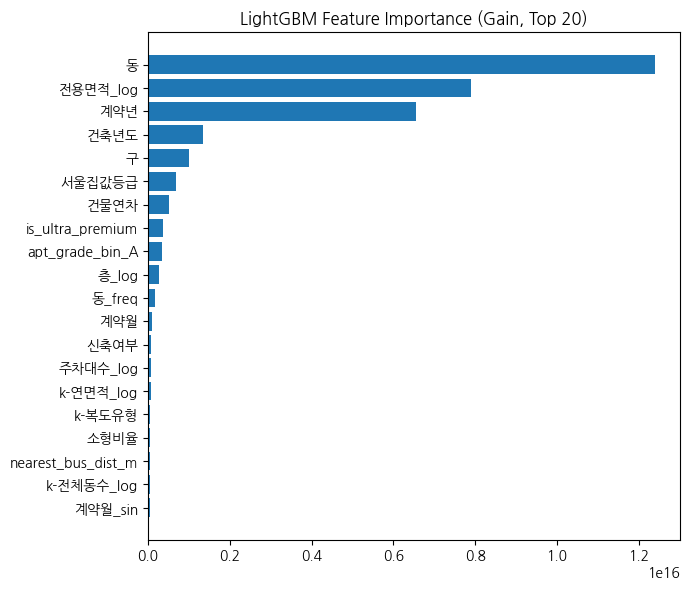

In [113]:
# 한글 폰트 설정
import matplotlib

matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

import matplotlib.pyplot as plt
imp = pd.DataFrame({
    "feature": lgbm.feature_name_,
    "gain": lgbm.booster_.feature_importance(importance_type="gain")
}).sort_values("gain", ascending=False).head(20)

plt.figure(figsize=(7,6))
plt.barh(imp["feature"][::-1], imp["gain"][::-1])
plt.title("LightGBM Feature Importance (Gain, Top 20)")
plt.tight_layout(); plt.show()

In [117]:
# 랜덤포레스트 모델 학습
model = RandomForestRegressor(n_estimators=500,criterion='squared_error',random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [118]:
from sklearn import metrics
import numpy as np

def evaluate_regression(model, X_train, y_train, X_val, y_val,
                        overfit_gap=0.10,         # R² 차이 기준 (train - val)
                        rmse_ratio_thr=1.50,      # RMSE 비율 기준 (val/train)
                        good_r2=0.80,             # 충분히 높은 R² 기준
                        low_r2=0.60,              # 낮은 R² 기준 (과소적합 의심)
                        high_err_rate=0.20        # 높은 오차율 기준 (RMSE / mean(y))
                       ):
    """
    회귀 모델 성능 평가 + 과적합/과소적합 진단
    - 지표: R², MAE, RMSE, 평균대비오차율(RMSE/mean(y))
    - 진단 규칙(기본):
        • 과적합: R²_gap >= 0.10 또는 RMSE 비율 >= 1.50 이면서 train R²는 충분히 높음
        • 과소적합: train/val R² 둘 다 낮거나, 오차율이 높고 두 세트 성능이 모두 안 좋음
        • 정상/양호: 위 두 조건이 아니면
    """

    # ---- 예측 ----
    pred_train = model.predict(X_train)
    pred_val   = model.predict(X_val)

    # ---- 훈련 지표 ----
    mae_train  = metrics.mean_absolute_error(y_train, pred_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    r2_train   = metrics.r2_score(y_train, pred_train)
    err_train  = rmse_train / (np.mean(y_train) + 1e-12)

    # ---- 검증 지표 ----
    mae_val  = metrics.mean_absolute_error(y_val, pred_val)
    rmse_val = np.sqrt(metrics.mean_squared_error(y_val, pred_val))
    r2_val   = metrics.r2_score(y_val, pred_val)
    err_val  = rmse_val / (np.mean(y_val) + 1e-12)

    # ---- 진단 지표 ----
    r2_gap        = max(0.0, r2_train - r2_val)
    rmse_ratio    = (rmse_val / (rmse_train + 1e-12))

    # ---- 과적합/과소적합 판정 ----
    is_overfit = (r2_train >= good_r2) and ((r2_gap >= overfit_gap) or (rmse_ratio >= rmse_ratio_thr))
    is_underfit = ((r2_train < low_r2) and (r2_val < low_r2)) or ((err_train >= high_err_rate) and (err_val >= high_err_rate))

    if is_overfit and not is_underfit:
        diagnosis = "overfitting"
    elif is_underfit and not is_overfit:
        diagnosis = "underfitting"
    elif is_overfit and is_underfit:
        diagnosis = "inconclusive (both symptoms)"  # 드문 케이스
    else:
        diagnosis = "well-fit"

    # ---- 출력 ----
    print("=== 훈련 세트 성능 ===")
    print(f"R²        : {r2_train:.4f}")
    print(f"MAE       : {mae_train:,.4f}")
    print(f"RMSE      : {rmse_train:,.4f}")
    print(f"오차율    : {err_train:.4%}")

    print("\n=== 검증 세트 성능 ===")
    print(f"R²        : {r2_val:.4f}")
    print(f"MAE       : {mae_val:,.4f}")
    print(f"RMSE      : {rmse_val:,.4f}")
    print(f"오차율    : {err_val:.4%}")

    print("\n=== 진단 보조 지표 ===")
    print(f"R² gap (train - val) : {r2_gap:.4f}")
    print(f"RMSE ratio (val/train): {rmse_ratio:.3f}")
    print(f"\n>>> Diagnosis: {diagnosis}")

    return {
        "train": {"R2": r2_train, "MAE": mae_train, "RMSE": rmse_train, "ErrorRate": err_train},
        "valid": {"R2": r2_val, "MAE": mae_val, "RMSE": rmse_val, "ErrorRate": err_val},
        "diagnostics": {"R2_gap": r2_gap, "RMSE_ratio": rmse_ratio, "diagnosis": diagnosis},
        "thresholds": {
            "overfit_gap": overfit_gap,
            "rmse_ratio_thr": rmse_ratio_thr,
            "good_r2": good_r2,
            "low_r2": low_r2,
            "high_err_rate": high_err_rate
        }
    }

# 사용 예시
model.fit(X_train, y_train)
results = evaluate_regression(model, X_train, y_train, X_val, y_val)


=== 훈련 세트 성능 ===
R²        : 0.9966
MAE       : 1,224.3258
RMSE      : 2,701.0530
오차율    : 4.6567%

=== 검증 세트 성능 ===
R²        : 0.9758
MAE       : 3,183.4529
RMSE      : 7,259.6443
오차율    : 12.5286%

=== 진단 보조 지표 ===
R² gap (train - val) : 0.0208
RMSE ratio (val/train): 2.688

>>> Diagnosis: overfitting
